Talk about random forest and how it works. Write specific context about its use cases here with this data.

In [1]:
# Import libraries and data

import pandas as pd
import numpy as np
from sklearn.model_selection import LeaveOneOut, StratifiedKFold, train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, confusion_matrix, roc_auc_score
import seaborn as sns
import matplotlib.pyplot as plt

df = pd.read_csv('data/alzheimers.csv')

In [2]:
# Define function for model comparison

def collect_metrics(y_true, y_pred, method_name):
    return {
        'method': method_name,
        'accuracy': accuracy_score(y_true, y_pred),
        'precision': precision_score(y_true, y_pred),
        'recall': recall_score(y_true, y_pred),
        'f1_score': f1_score(y_true, y_pred)
    }

In [3]:
# Prepare data

# Seperate into target and predictors
X = df.drop('Diagnosis', axis=1)
X = X.drop('PatientID', axis=1)
X = X.drop('DoctorInCharge', axis=1)
y = df['Diagnosis']

# Identify column types
categorical_cols = X.select_dtypes(include=['object', 'category']).columns.tolist()
numeric_cols = X.select_dtypes(include=['int64', 'float64']).columns.tolist()

# Preprocessing and model pipeline
preprocessor = ColumnTransformer([
    ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols),
    ('num', 'passthrough', numeric_cols)
])
clf = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(random_state=49))
])

Write about model hyperparameters, why they are important and how grid search can be used to optimize model fitting.

In [4]:
# Perform grid search for optimal hyperparameters and update classifier pipeline

# Define hyperparameter grid
param_grid = {
    'classifier__n_estimators': list(range(25, 200, 25)),
    'classifier__max_depth': [None] + list(range(5, 20, 5)),
    'classifier__min_samples_split': list(range(2, 10)),
    'classifier__min_samples_leaf': list(range(1, 15, 2)),
    'classifier__max_features': ['sqrt', 'log2']
}

# Create GridSearchCV using Stratified K-Fold for classification
grid_search = GridSearchCV(
    clf,
    param_grid,
    cv=5,
    scoring='f1',
    n_jobs=-1,  # Use all processor cores to speed up grid search
    verbose=1
)

# Fit the grid search
grid_search.fit(X, y)

# Print the results
print("Best Parameters:", grid_search.best_params_)
print("Best F1 Score:", grid_search.best_score_)

# Update parameters for subsequent model evaluation
best_clf = grid_search.best_estimator_
clf = best_clf

Fitting 5 folds for each of 3136 candidates, totalling 15680 fits
Best Parameters: {'classifier__max_depth': 15, 'classifier__max_features': 'sqrt', 'classifier__min_samples_leaf': 1, 'classifier__min_samples_split': 5, 'classifier__n_estimators': 75}
Best F1 Score: 0.9127858586596667


Talk about cross validation methods and standard test train split and why we use it.

In [5]:
# Fit random forest model using optimized hyperparameters and test/train split

metrics_list = []

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=49)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

metrics_list.append(collect_metrics(y_test, y_pred, method_name='Train/Test Split'))

Talk about k fold cross validation, why we use it and why we settled on 10 folds here.

In [6]:
# K-Fold

kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=49)
y_true_kf = []
y_pred_kf = []

for train_idx, test_idx in kfold.split(X, y):
    clf.fit(X.iloc[train_idx], y.iloc[train_idx])
    pred = clf.predict(X.iloc[test_idx])
    y_true_kf.extend(y.iloc[test_idx])
    y_pred_kf.extend(pred)

metrics_list.append(collect_metrics(y_true_kf, y_pred_kf, method_name='Stratified K-Fold'))

Talk about leave one out cross validation and make sure to highlight computational inefficiency.

In [7]:
# Leave-One-Out Cross-Validation

loo = LeaveOneOut()
y_true_loo = []
y_pred_loo = []

for train_idx, test_idx in loo.split(X):
    clf.fit(X.iloc[train_idx], y.iloc[train_idx])
    pred = clf.predict(X.iloc[test_idx])
    y_true_loo.append(y.iloc[test_idx].values[0])
    y_pred_loo.append(pred[0])

metrics_list.append(collect_metrics(y_true_loo, y_pred_loo, method_name='LOOCV'))

In the final latex document we will need to make sure we use this data to compare model fits using various methods. Also talk about these metrics and why they matter, plus why we didn't use something else such as AUC-ROC.

In [8]:
# Compare results of model fitting

results_df = pd.DataFrame(metrics_list)
print(results_df)

              method  accuracy  precision    recall  f1_score
0   Train/Test Split  0.958140   0.946667  0.934211  0.940397
1  Stratified K-Fold  0.942764   0.950495  0.884211  0.916155
2              LOOCV  0.948348   0.952580  0.898684  0.924848


Summary, even though tghere is essentially no performance difference between cross validation types here we should use k-fold CV as the preffered method as it is expected to perform better than a standard test-train split on larger and more complex datasets and LOOCV is far too computationally expensive to scale well to other data.

                  Accuracy  Precision    Recall  F1 Score   ROC AUC
Train/Test Split  0.997674        1.0  0.993421    0.9967  0.999976


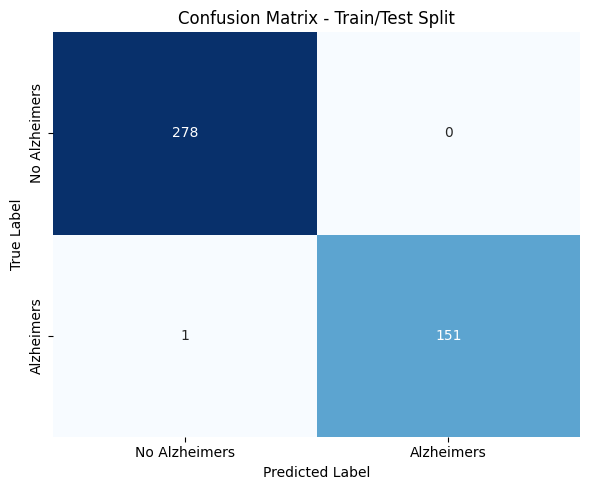

In [10]:
# Predict using the trained model from Train/Test Split
y_pred = clf.predict(X_test)
y_proba = clf.predict_proba(X_test)[:, 1]  # Needed for ROC AUC

# Collect performance metrics
metrics = {
    'Accuracy': accuracy_score(y_test, y_pred),
    'Precision': precision_score(y_test, y_pred),
    'Recall': recall_score(y_test, y_pred),
    'F1 Score': f1_score(y_test, y_pred),
    'ROC AUC': roc_auc_score(y_test, y_proba)
}

# Convert to DataFrame
metrics_df = pd.DataFrame(metrics, index=['Train/Test Split'])
print(metrics_df)

# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred)
labels = ['No Alzheimers', 'Alzheimers']

# Plot confusion matrix
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=labels, yticklabels=labels, cbar=False)

plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix - Train/Test Split')
plt.tight_layout()
plt.show()